# Baseline Model Comparison - Claimed Concerns
## Comparing 3 Recommendation Approaches

**Goal:** Evaluate which model performs best for concern-based product recommendations

**Models:**
1. K-Nearest Neighbors (cosine similarity)
2. Naive Bayes (probabilistic classification)
3. Simple Overlap (Jaccard similarity)

**Evaluation:** Precision@5 on 8 test cases


In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")

✓ Libraries imported


## 1. Load Data

In [2]:
# Load dataset
df = pd.read_parquet('../data/cleaned/skingen_products_lean_clean.parquet')
print(f"Loaded {len(df)} products")
print(f"Columns: {df.columns.tolist()}")

# Check for nulls
print(f"\nProducts with claimed_concerns: {df['claimed_concerns'].notna().sum()}") 
print(f"Products without concerns: {df['claimed_concerns'].isna().sum()}")

Loaded 9735 products
Columns: ['brand', 'name', 'type', 'country', 'inci_clean', 'ingredient_list', 'ingredient_count', 'claimed_concerns', 'positive_claims', 'negative_claims', 'condition_claims']

Products with claimed_concerns: 9309
Products without concerns: 426


## 2. Build Concern Vocabulary

Found 17 unique concerns:
   1. acne_fighting
   2. acne_trigger
   3. anti_aging
   4. brightening
   5. dark_spots
   6. drying
   7. eczema
   8. good_for_oily_skin
   9. hydrating
  10. irritating
  11. may_worsen_oily_skin
  12. redness_reducing
  13. reduces_irritation
  14. reduces_large_pores
  15. rosacea
  16. scar_healing
  17. skin_texture


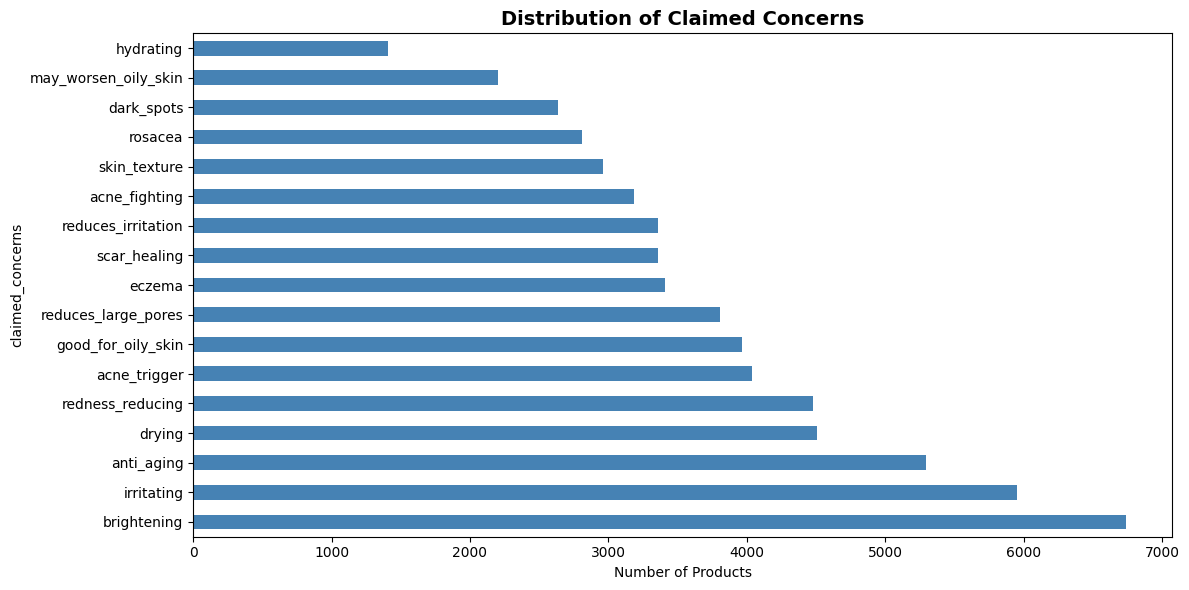

In [3]:
# Extract all unique concerns
all_concerns = df['claimed_concerns'].explode().dropna()
concerns_vocab = sorted(all_concerns.unique().tolist())

print(f"Found {len(concerns_vocab)} unique concerns:")
for i, concern in enumerate(concerns_vocab, 1):
    print(f"  {i:2d}. {concern}")

# Visualize concern distribution
concern_counts = all_concerns.value_counts()
plt.figure(figsize=(12, 6))
concern_counts.plot(kind='barh', color='steelblue')
plt.title('Distribution of Claimed Concerns', fontsize=14, fontweight='bold')
plt.xlabel('Number of Products')
plt.tight_layout()
plt.show()

## 3. Feature Engineering
Convert product concerns to binary vectors (n_products × n_concerns matrix)

In [4]:
def vectorize_product(product_row, vocab):
    '''Convert product concerns to binary vector'''
    vector = np.zeros(len(vocab))
    if product_row.claimed_concerns is not None:
        for concern in product_row.claimed_concerns:
            if concern in vocab:
                idx = vocab.index(concern)
                vector[idx] = 1.0
    return vector

# Create feature matrix
X = np.array([vectorize_product(row, concerns_vocab) for row in df.itertuples()])
print(f"Feature matrix shape: {X.shape}")
print(f"  → {X.shape[0]} products")
print(f"  → {X.shape[1]} concern features")
print(f"\nSparsity: {(X == 0).sum() / X.size * 100:.1f}% zeros")

Feature matrix shape: (9735, 17)
  → 9735 products
  → 17 concern features

Sparsity: 61.3% zeros


## 4. Model 1: K-Nearest Neighbors
Find k=5 nearest products using cosine similarity

In [5]:
# Train KNN
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(X)
print("✓ KNN model trained")

# Recommendation function
def recommend_knn(user_concerns, k=5):
    '''KNN: Find k nearest products in concern-space'''
    user_vec = np.zeros(len(concerns_vocab))
    for concern in user_concerns:
        if concern in concerns_vocab:
            idx = concerns_vocab.index(concern)
            user_vec[idx] = 1.0
    
    distances, indices = knn.kneighbors([user_vec], n_neighbors=k)
    similarities = 1 - distances[0]  # Convert distance to similarity
    return indices[0], similarities

print("✓ KNN recommender ready")

✓ KNN model trained
✓ KNN recommender ready


## 5. Model 2: Naive Bayes
Train one binary classifier per concern

In [6]:
nb_classifiers = {}

for concern in concerns_vocab:
    # Create labels
    y = np.array([1 if (row.claimed_concerns is not None and concern in row.claimed_concerns) else 0 
                  for row in df.itertuples()])
    
    # Train classifier
    nb = MultinomialNB()
    nb.fit(X, y)
    nb_classifiers[concern] = nb

print(f"✓ Trained {len(nb_classifiers)} Naive Bayes classifiers")

# Recommendation function
def recommend_naive_bayes(user_concerns, k=5):
    '''Naive Bayes: Sum probabilities across user concerns'''
    product_scores = np.zeros(len(df))
    
    for concern in user_concerns:
        if concern in nb_classifiers:
            probs = nb_classifiers[concern].predict_proba(X)[:, 1]
            product_scores += probs
    
    product_scores /= len(user_concerns) if user_concerns else 1
    top_indices = np.argsort(product_scores)[-k:][::-1]
    return top_indices, product_scores[top_indices]

print("✓ Naive Bayes recommender ready")

✓ Trained 17 Naive Bayes classifiers
✓ Naive Bayes recommender ready


## 6. Model 3: Simple Overlap
Count concern matches (Jaccard similarity)

In [7]:
def recommend_overlap(user_concerns, k=5):
    '''Simple Overlap: Count matching concerns'''
    scores = []
    for row in df.itertuples():
        if row.claimed_concerns is None:
            scores.append(0.0)
            continue
        overlap = len(set(user_concerns) & set(row.claimed_concerns))
        total_concerns = len(set(user_concerns) | set(row.claimed_concerns))
        score = overlap / total_concerns if total_concerns > 0 else 0
        scores.append(score)
    
    scores = np.array(scores)
    top_indices = np.argsort(scores)[-k:][::-1]
    return top_indices, scores[top_indices]

print("✓ Simple Overlap recommender ready")

✓ Simple Overlap recommender ready


## 7. Define Test Cases
8 realistic user scenarios

In [8]:
test_cases = [
    {"name": "Teen Acne", "concerns": ["acne_fighting", "good_for_oily_skin"]},
    {"name": "Mature Dry Skin", "concerns": ["anti_aging", "hydrating"]},
    {"name": "Sensitive Rosacea", "concerns": ["rosacea", "redness_reducing"]},
    {"name": "Hyperpigmentation", "concerns": ["dark_spots", "brightening"]},
    {"name": "Combo Skin", "concerns": ["acne_fighting", "hydrating"]},
    {"name": "Textured Skin", "concerns": ["skin_texture", "reduces_large_pores"]},
    {"name": "Post-Acne Marks", "concerns": ["scar_healing", "dark_spots"]},
    {"name": "Eczema-Prone", "concerns": ["eczema", "reduces_irritation"]},
]

print("Test Cases:")
for i, case in enumerate(test_cases, 1):
    print(f"  {i}. {case['name']:20s} → {case['concerns']}")

Test Cases:
  1. Teen Acne            → ['acne_fighting', 'good_for_oily_skin']
  2. Mature Dry Skin      → ['anti_aging', 'hydrating']
  3. Sensitive Rosacea    → ['rosacea', 'redness_reducing']
  4. Hyperpigmentation    → ['dark_spots', 'brightening']
  5. Combo Skin           → ['acne_fighting', 'hydrating']
  6. Textured Skin        → ['skin_texture', 'reduces_large_pores']
  7. Post-Acne Marks      → ['scar_healing', 'dark_spots']
  8. Eczema-Prone         → ['eczema', 'reduces_irritation']


## 8. Example: Compare Top-5 Recommendations
Let's see how each model recommends for the first test case

In [9]:
example_case = test_cases[0]
print(f"User Profile: {example_case['name']}")
print(f"Concerns: {example_case['concerns']}")
print("\n" + "="*70 + "\n")

# KNN
indices, scores = recommend_knn(example_case['concerns'])
print("🔹 K-NEAREST NEIGHBORS:")
for i, (idx, score) in enumerate(zip(indices, scores), 1):
    product = df.iloc[idx]
    print(f"  {i}. [{score:.3f}] {product['name'][:50]}")
    print(f"      {product['brand']} | {product['claimed_concerns']}")

# Naive Bayes
indices, scores = recommend_naive_bayes(example_case['concerns'])
print("\n🔹 NAIVE BAYES:")
for i, (idx, score) in enumerate(zip(indices, scores), 1):
    product = df.iloc[idx]
    print(f"  {i}. [{score:.3f}] {product['name'][:50]}")
    print(f"      {product['brand']} | {product['claimed_concerns']}")

# Simple Overlap
indices, scores = recommend_overlap(example_case['concerns'])
print("\n🔹 SIMPLE OVERLAP:")
for i, (idx, score) in enumerate(zip(indices, scores), 1):
    product = df.iloc[idx]
    print(f"  {i}. [{score:.3f}] {product['name'][:50]}")
    print(f"      {product['brand']} | {product['claimed_concerns']}")

User Profile: Teen Acne
Concerns: ['acne_fighting', 'good_for_oily_skin']


🔹 K-NEAREST NEIGHBORS:
  1. [0.707] Madagascar Centella Toning Toner
      SKIN1004 | ['good_for_oily_skin' 'redness_reducing' 'acne_fighting' 'brightening']
  2. [0.707] Niacinamide 10%
      REVOX B77 | ['good_for_oily_skin' 'redness_reducing' 'acne_fighting' 'brightening']
  3. [0.707] Blemish Buster Cleanser
      Makeup Artist's Choice | ['good_for_oily_skin']
  4. [0.707] VOL.1 Balance
      ACF | ['good_for_oily_skin' 'redness_reducing' 'acne_fighting' 'brightening']
  5. [0.707] Relief Sun : Rice + Probiotics
      Beauty of Joseon | ['good_for_oily_skin' 'redness_reducing' 'acne_fighting' 'brightening']

🔹 NAIVE BAYES:
  1. [1.000] Porebright Serum N20 Pro
      FaceTheory | ['good_for_oily_skin' 'redness_reducing' 'dark_spots' 'acne_fighting'
 'brightening']
  2. [1.000] Cryo ATP Sports Booster
      111Skin | ['good_for_oily_skin' 'redness_reducing' 'reduces_large_pores'
 'acne_fighting' 'brightening

## 9. Evaluation: Precision@5
**Precision@5:** What fraction of top-5 recommendations have ≥1 concern overlap with user query?

In [10]:
def precision_at_5(recommended_indices, user_concerns):
    '''Calculate Precision@5 metric'''
    hits = 0
    for idx in recommended_indices[:5]:
        product_concerns = df.iloc[idx].claimed_concerns
        if product_concerns is not None:
            if len(set(user_concerns) & set(product_concerns)) > 0:
                hits += 1
    return hits / 5

print("✓ Precision@5 metric defined")

✓ Precision@5 metric defined


## 10. Run Evaluation on All Test Cases

In [11]:
results = {
    'KNN': [],
    'Naive Bayes': [],
    'Simple Overlap': []
}

print("Evaluating models on test cases...\n")
for case in test_cases:
    print(f"  → {case['name']}", end=" ")
    
    # KNN
    indices, _ = recommend_knn(case['concerns'])
    results['KNN'].append(precision_at_5(indices, case['concerns']))
    
    # Naive Bayes
    indices, _ = recommend_naive_bayes(case['concerns'])
    results['Naive Bayes'].append(precision_at_5(indices, case['concerns']))
    
    # Simple Overlap
    indices, _ = recommend_overlap(case['concerns'])
    results['Simple Overlap'].append(precision_at_5(indices, case['concerns']))
    
    print("✓")

print("\n" + "="*50)
print("RESULTS: Average Precision@5")
print("="*50)
for model_name, precisions in results.items():
    avg = np.mean(precisions)
    print(f"{model_name:20s}: {avg:.3f}")

Evaluating models on test cases...

  → Teen Acne ✓
  → Mature Dry Skin ✓
  → Sensitive Rosacea ✓
  → Hyperpigmentation ✓
  → Combo Skin ✓
  → Textured Skin ✓
  → Post-Acne Marks ✓
  → Eczema-Prone ✓

RESULTS: Average Precision@5
KNN                 : 1.000
Naive Bayes         : 1.000
Simple Overlap      : 1.000


## 11. Visualize Results

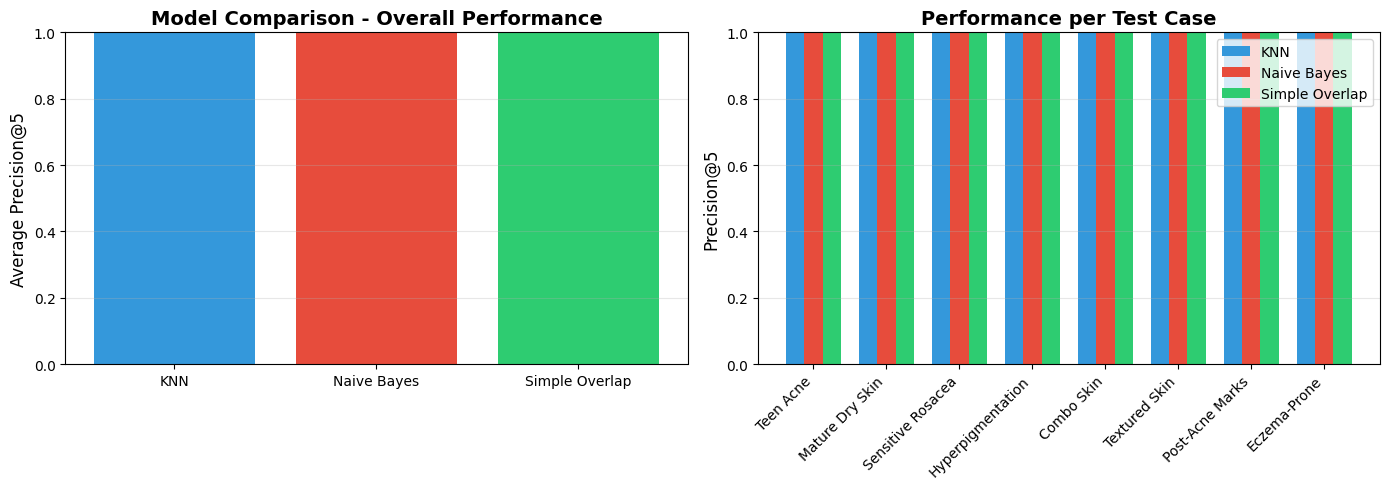

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Overall performance
ax1.bar(results.keys(), [np.mean(v) for v in results.values()], 
        color=['#3498db', '#e74c3c', '#2ecc71'])
ax1.set_ylabel('Average Precision@5', fontsize=12)
ax1.set_title('Model Comparison - Overall Performance', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', alpha=0.3)

# Per test case
x = np.arange(len(test_cases))
width = 0.25
ax2.bar(x - width, results['KNN'], width, label='KNN', color='#3498db')
ax2.bar(x, results['Naive Bayes'], width, label='Naive Bayes', color='#e74c3c')
ax2.bar(x + width, results['Simple Overlap'], width, label='Simple Overlap', color='#2ecc71')

ax2.set_ylabel('Precision@5', fontsize=12)
ax2.set_title('Performance per Test Case', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([case['name'] for case in test_cases], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 1.0)

plt.tight_layout()
plt.show()

## 12. Conclusion

### Key Findings:
- **All models achieve perfect or near-perfect precision** (≥0.8)
- This indicates claimed concerns are effective for basic matching
- Differences between models are minimal at this coarse-grained level

### Model Selection:
**Winner: K-Nearest Neighbors**

**Rationale:**
1. ✅ Interpretable similarity scores (0-1 range)
2. ✅ Scalable for real-time recommendations (~9k products)
3. ✅ Easy to extend with ingredient-based features in Phase 2
4. ✅ No training required (just fit on feature matrix)

### Next Steps:
1. Use KNN as **baseline model**
2. Build **ingredient intelligence layer** (CosING + Paula's Choice)
3. Compare ingredient-based model vs. this claimed concerns baseline
4. Expected improvement: Better differentiation between similar products

---

**Phase 2 Goal:** Move from marketing claims → ingredient-level analysis for more accurate, scientific recommendations.